In [3]:
# !pip install --upgrade openpyxl
# !pip install --upgrade --user scikit-learn
# !pip install threadpoolctl==3.1.0
import pandas as pd
import numpy as np

In [4]:
# Data loading
data_sheet = ['지역별(부산제외)', '기간별(부산제외)', '성별(부산제외)', '연령대별(부산제외)', '요일별(부산제외)', '시간대별(부산제외)']
data = {}

for sheet_name in data_sheet:
    temp = pd.read_excel("./data/부산관광공사_관광지별 유동인구_20221231.xlsx", sheet_name=sheet_name)
    data[sheet_name] = temp


# Data Preprocess
각 데이터에서 군집화에 사용할 칼럼을 특정, 파생변수 생성

In [5]:
cluster_dataset = []

## 지역별 데이터
* 지역을 묶어서 방문객 수를 집계 후 21년대비 증감률을 이용
* 지역은 수도권(서울, 경기, 인천)과 영남권(부산, 울산, 대구, 경남, 경북)을 이용

In [6]:
location_data = data['지역별(부산제외)'][['관광지', '21년대비 수도권 증감률', '수도권 구성비', '21년대비 영남권 증감률', '영남권 구성비']]
location_data.head()

,관광지,21년대비 수도권 증감률,수도권 구성비,21년대비 영남권 증감률,영남권 구성비
0,부산 서면,0.836734,0.340191,0.711818,0.518882
1,해운대시장,0.861863,0.545287,0.886272,0.259735
2,해운대 해수욕장,0.712085,0.550674,0.755022,0.257095
3,센텀시티,0.804727,0.409028,0.885309,0.430134
4,광안리 해수욕장,1.037190,0.487743,0.976449,0.325381


In [7]:
cluster_dataset.append(location_data)

## 기간별 데이터
모든 지역에서 기간별 방문객 비율 분포가 유사하여 데이터로써 의미가 없다고 판단, 군집화에 사용하지 않음

In [8]:
data['기간별(부산제외)'].head(10)

,순위,관광지,2022년 5월연휴주,2022년 여름휴가,2022년 10월연휴주,21년대비 성장률
0,1,부산 서면,171570,770831,183666,0.829659
1,2,해운대시장,116112,733173,133334,0.979028
2,3,해운대 해수욕장,109633,594134,104151,0.828477
3,4,센텀시티,95229,437337,120247,0.947818
4,5,광안리 해수욕장,66866,335142,69612,1.123678
5,6,자갈치_국제시장,54931,257099,68756,1.532546
6,7,오시리아,37627,138335,42315,1.030012
7,8,가덕도,15368,62347,34037,0.039737
8,9,기장해변_대변항,19302,62158,16069,0.233124
9,10,동백섬 일원,15490,78123,13859,0.797912


## 시간대별 데이터
* 주간 방문 (12시~19시)과 야간 방문 (20시~03시)의 비율을 이용

In [9]:
data['시간대별(부산제외)'].head(10)

,순위,관광지,00시~03시,04~07시,08~11시,12시~15시,16시~19시,20시~23시
0,1,부산 서면,177398,145322,158047,192646,238621,214034
1,2,해운대시장,168887,166575,162970,134746,175534,173907
2,3,해운대 해수욕장,139424,136909,133514,108379,145218,144476
3,4,센텀시티,73102,69942,94804,152168,167415,95382
4,5,광안리 해수욕장,77242,70271,68285,60841,92578,102403
5,6,자갈치_국제시장,46284,42585,46273,72358,95608,77678
6,7,오시리아,20692,20668,30812,54183,63774,28148
7,8,가덕도,11179,10798,21621,24561,25626,17966
8,9,기장해변_대변항,8855,8841,13714,24108,29599,12413
9,10,동백섬 일원,18626,19045,18858,14335,18592,18016


In [10]:
temp = data['시간대별(부산제외)']

In [11]:
temp['합계'] = temp.iloc[:, 2:].sum(axis=1)
temp['주간방문 비율'] = (temp['12시~15시'] + temp['16시~19시']) / temp['합계']
temp['야간방문 비율'] = (temp['00시~03시'] + temp['20시~23시']) / temp['합계']
temp.head()

,순위,관광지,00시~03시,04~07시,08~11시,12시~15시,16시~19시,20시~23시,합계,주간방문 비율,야간방문 비율
0,1,부산 서면,177398,145322,158047,192646,238621,214034,1126068,0.382985,0.347610
1,2,해운대시장,168887,166575,162970,134746,175534,173907,982619,0.315768,0.348857
2,3,해운대 해수욕장,139424,136909,133514,108379,145218,144476,807920,0.313889,0.351396
3,4,센텀시티,73102,69942,94804,152168,167415,95382,652813,0.489548,0.258089
4,5,광안리 해수욕장,77242,70271,68285,60841,92578,102403,471620,0.325302,0.380910


In [12]:
time_data = temp[['관광지','주간방문 비율', '야간방문 비율']]
cluster_dataset.append(time_data)

## 요일별 데이터

In [13]:
date_data = data['요일별(부산제외)'][['관광지', '주말(토일)집중도 ']]
cluster_dataset.append(date_data)

# Clustering

In [14]:
data['성별(부산제외)']['합계'] = data['성별(부산제외)'].iloc[:,2:].sum(axis=1)
base = data['성별(부산제외)'][['관광지', '합계']]

for df in cluster_dataset:
    base = base.merge(df, on='관광지')

base.head()

,관광지,합계,21년대비 수도권 증감률,수도권 구성비,21년대비 영남권 증감률,영남권 구성비,주간방문 비율,야간방문 비율,주말(토일)집중도
0,부산 서면,1126067,0.836734,0.340191,0.711818,0.518882,0.382985,0.347610,0.402876
1,해운대시장,982619,0.861863,0.545287,0.886272,0.259735,0.315768,0.348857,0.381916
2,해운대 해수욕장,807918,0.712085,0.550674,0.755022,0.257095,0.313889,0.351396,0.381744
3,센텀시티,652813,0.804727,0.409028,0.885309,0.430134,0.489548,0.258089,0.417336
4,광안리 해수욕장,471619,1.037190,0.487743,0.976449,0.325381,0.325302,0.380910,0.405596


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
base['합계_표준화'] = scaler.fit_transform(np.array(base['합계']).reshape(-1,1))

In [16]:
base.head()

,관광지,합계,21년대비 수도권 증감률,수도권 구성비,21년대비 영남권 증감률,영남권 구성비,주간방문 비율,야간방문 비율,주말(토일)집중도,합계_표준화
0,부산 서면,1126067,0.836734,0.340191,0.711818,0.518882,0.382985,0.347610,0.402876,4.041436
1,해운대시장,982619,0.861863,0.545287,0.886272,0.259735,0.315768,0.348857,0.381916,3.467005
2,해운대 해수욕장,807918,0.712085,0.550674,0.755022,0.257095,0.313889,0.351396,0.381744,2.767422
3,센텀시티,652813,0.804727,0.409028,0.885309,0.430134,0.489548,0.258089,0.417336,2.146311
4,광안리 해수욕장,471619,1.037190,0.487743,0.976449,0.325381,0.325302,0.380910,0.405596,1.420727


In [17]:
Cluster_Values = base.iloc[:,2:]

In [18]:
Cluster_Values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   21년대비 수도권 증감률  50 non-null     float64
 1   수도권 구성비        50 non-null     float64
 2   21년대비 영남권 증감률  50 non-null     float64
 3   영남권 구성비        50 non-null     float64
 4   주간방문 비율        50 non-null     float64
 5   야간방문 비율        50 non-null     float64
 6   주말(토일)집중도      50 non-null     float64
 7   합계_표준화         50 non-null     float64
dtypes: float64(8)
memory usage: 3.2 KB


In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0)
base['군집'] = kmeans.fit_predict(Cluster_Values)

C:\Users\bonjo\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\bonjo\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [31]:
base.head(50)

,관광지,합계,21년대비 수도권 증감률,수도권 구성비,21년대비 영남권 증감률,영남권 구성비,주간방문 비율,야간방문 비율,주말(토일)집중도,합계_표준화,군집
0,부산 서면,1126067,0.836734,0.340191,0.711818,0.518882,0.382985,0.347610,0.402876,4.041436,0
1,해운대시장,982619,0.861863,0.545287,0.886272,0.259735,0.315768,0.348857,0.381916,3.467005,0
2,해운대 해수욕장,807918,0.712085,0.550674,0.755022,0.257095,0.313889,0.351396,0.381744,2.767422,0
3,센텀시티,652813,0.804727,0.409028,0.885309,0.430134,0.489548,0.258089,0.417336,2.146311,4
4,광안리 해수욕장,471619,1.037190,0.487743,0.976449,0.325381,0.325302,0.380910,0.405596,1.420727,4
5,자갈치_국제시장,380786,1.569861,0.434136,1.142843,0.370082,0.441103,0.325542,0.429653,1.056990,4
6,오시리아,218278,1.105540,0.303012,0.792976,0.555583,0.540401,0.223752,0.424626,0.406233,2
7,가덕도,111752,0.374706,0.064493,0.014935,0.912614,0.449097,0.260803,0.410449,-0.020346,1
8,기장해변_대변항,97530,0.272613,0.318361,0.082838,0.561041,0.550672,0.218066,0.427007,-0.077297,1
9,동백섬 일원,107471,0.677687,0.554952,0.690928,0.252895,0.306377,0.340945,0.391678,-0.037489,2


In [32]:
base.to_excel('./군집화결과_군집6개.xlsx')

C:\Users\bonjo\AppData\Local\Temp/ipykernel_8416/2881060059.py:1: UserWarning: Pandas requires version '3.0.3' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  base.to_excel('./군집화결과_군집6개.xlsx')


In [26]:
import matplotlib.pyplot as plt

def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 10):
        km = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(range(1, 10), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

C:\Users\bonjo\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonjo\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonjo\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\bonjo\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmea

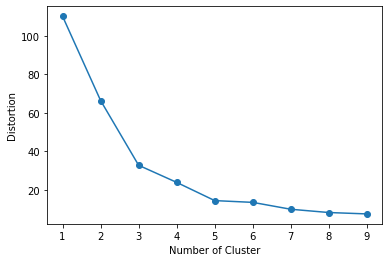

In [27]:
visualize_elbowmethod(Cluster_Values)